In [1]:
from google.colab import drive
drive.mount('/content/datasets')

Mounted at /content/datasets


In [2]:
path = "/content/datasets/MyDrive/preprocessed_01.csv"

In [3]:
import pandas as pd
df = pd.read_csv(path)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      1205 non-null   int64  
 1   본사정원수           1205 non-null   float64
 2   본사휴가자수          1205 non-null   float64
 3   본사출장자수          1205 non-null   float64
 4   본사시간외근무명령서승인건수  1205 non-null   float64
 5   현본사소속재택근무자수     1205 non-null   float64
 6   day             1205 non-null   int64  
 7   morning_menu    1205 non-null   object 
 8   lunch_menu      1205 non-null   object 
 9   dinner_menu     1205 non-null   object 
 10  중식계             1205 non-null   float64
 11  석식계             1205 non-null   float64
dtypes: float64(7), int64(2), object(3)
memory usage: 113.1+ KB


In [5]:
import matplotlib.pyplot as plt

def drawHistory(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(loss) + 1)
    
    plt.figure()
    plt.plot(epochs, loss, 'ro', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
    plt.show()

In [6]:
from tensorflow.keras import layers, Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [7]:
food = df['lunch_menu']
tokenizer = Tokenizer()
tokenizer.fit_on_texts(food)

In [8]:
len(tokenizer.word_index)

1723

In [11]:
from keras.preprocessing import sequence
max_len=9

lunch_vector = tokenizer.texts_to_sequences(df['lunch_menu'])
lunch_train_x = sequence.pad_sequences(lunch_vector, maxlen=max_len)

lunch_train_x.shape

(1205, 9)

In [12]:
other_train_x = df[['본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수', 'day']]

In [13]:
y_train = df['중식계']

In [36]:
callbacks_list = [
    EarlyStopping(monitor='val_loss', patience=3),
    ModelCheckpoint(filepath='lunch.h5', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
]

In [15]:
val_lunch = lunch_train_x[1000:]
lunch_train = lunch_train_x[:1000]

val_other = other_train_x[1000:]
other_train = other_train_x[:1000]

val_y_lunch = y_train[1000:]
y_lunch_train = y_train[:1000]

In [21]:
lunch_train.shape, other_train.shape, y_lunch_train.shape

((1000, 9), (1000, 6), (1000,))

In [22]:
val_lunch.shape, val_other.shape, val_y_lunch.shape

((205, 9), (205, 6), (205,))

In [17]:
val_data = {
    'lunch': val_lunch, 'other':val_other
}

val_targets = {
    'lunch_target': val_y_lunch
}

In [18]:
lunch_input = Input(shape=(None,), dtype='int32', name='lunch')
other_input = Input(shape=(6, ), dtype='float64', name='other')

embedding = layers.Embedding(len(tokenizer.word_index)+1, 32, input_length=max_len, mask_zero=True)

lunch_x = embedding(lunch_input)
lunch_x = layers.GRU(16)(lunch_x)

other_x = layers.Dense(4, activation='relu', input_shape=(6,))(other_input)

concatenated = layers.concatenate([lunch_x, other_x], axis=-1)

lunch_dense = layers.Dense(16, activation='relu')(concatenated)
lunch_prediction = layers.Dense(1, name='lunch_target')(lunch_dense)

model = Model([lunch_input, other_input], lunch_prediction)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
lunch (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 32)     55168       lunch[0][0]                      
__________________________________________________________________________________________________
other (InputLayer)              [(None, 6)]          0                                            
__________________________________________________________________________________________________
gru (GRU)                       (None, 16)           2400        embedding[0][0]                  
______________________________________________________________________________________________

In [42]:
model.compile(optimizer='rmsprop', 
              loss='mae', 
              metrics=['mse'])

history = model.fit({'lunch': lunch_train, 'other':other_train}, y_lunch_train, 
                    epochs=200, 
                    batch_size=64, 
                    callbacks=callbacks_list,
                    validation_split=0.2,
                    # validation_data=(val_data, val_targets),
                    verbose=2)

Epoch 1/200
13/13 - 5s - loss: 90.1235 - mse: 14022.6250 - val_loss: 115.7090 - val_mse: 22694.7520
Epoch 2/200
13/13 - 0s - loss: 90.0689 - mse: 14008.7041 - val_loss: 115.4028 - val_mse: 22581.3848
Epoch 3/200
13/13 - 0s - loss: 89.9822 - mse: 13986.7188 - val_loss: 115.1811 - val_mse: 22506.5391
Epoch 4/200
13/13 - 0s - loss: 89.8851 - mse: 13973.2402 - val_loss: 115.0425 - val_mse: 22468.8125
Epoch 5/200
13/13 - 0s - loss: 89.8255 - mse: 13943.8379 - val_loss: 114.8748 - val_mse: 22422.0332
Epoch 6/200
13/13 - 0s - loss: 89.7558 - mse: 13914.2695 - val_loss: 114.5343 - val_mse: 22297.9746
Epoch 7/200
13/13 - 0s - loss: 89.7232 - mse: 13906.0811 - val_loss: 114.3638 - val_mse: 22249.2402
Epoch 8/200
13/13 - 0s - loss: 89.6656 - mse: 13884.5186 - val_loss: 114.1766 - val_mse: 22191.4727
Epoch 9/200
13/13 - 0s - loss: 89.5601 - mse: 13873.2354 - val_loss: 114.0809 - val_mse: 22175.3828
Epoch 10/200
13/13 - 0s - loss: 89.4986 - mse: 13839.8125 - val_loss: 113.8437 - val_mse: 22095.3281

In [43]:
model.evaluate(val_data, val_targets)

7/7 [==============================] - 1s 4ms/step - loss: 248.0332 - mse: 93009.2266


[248.0331573486328, 93009.2265625]

In [44]:
y = model.predict(val_data)

In [45]:
y[:5], val_y_lunch[:5]

(array([[ 679.351  ],
        [1323.8868 ],
        [1161.7172 ],
        [ 932.0711 ],
        [ 834.34827]], dtype=float32), 1000     642.0
 1001    1276.0
 1002    1019.0
 1003     967.0
 1004     804.0
 Name: 중식계, dtype: float64)

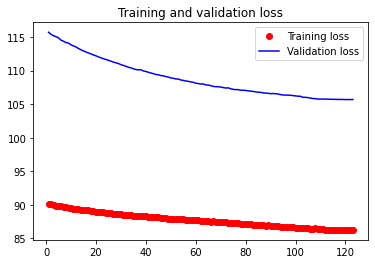

In [46]:
drawHistory(history)

In [47]:
from tensorflow.keras.models import load_model
saved_model = load_model('lunch.h5')
result = saved_model.predict(val_data)

In [48]:
result[:5], val_y_lunch[:5]

(array([[ 679.1534],
        [1323.6575],
        [1161.4674],
        [ 931.7801],
        [ 834.0551]], dtype=float32), 1000     642.0
 1001    1276.0
 1002    1019.0
 1003     967.0
 1004     804.0
 Name: 중식계, dtype: float64)

In [31]:
import numpy as np

test = pd.read_csv("/content/datasets/MyDrive/test.csv")

for col in ['본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수']:
    test[col] -= np.mean(test[col])
    test[col] /= np.std(test[col])

test['day'] = test['요일'].map({'월':0, '화':1, '수':2, '목':3, '금':4})

In [32]:
lunch_test_x = tokenizer.texts_to_sequences(test['중식메뉴'])
lunch_test_x = sequence.pad_sequences(lunch_test_x, maxlen=max_len)

other_test_x = test[['본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수', 'day']]

In [49]:
prediction = model.predict({'lunch': lunch_test_x, 
                            'other':other_test_x})

In [50]:
prediction[:5]

array([[ 67.055565],
       [ 47.90527 ],
       [ 39.185707],
       [407.4171  ],
       [354.7588  ]], dtype=float32)

In [51]:
prediction

array([[ 67.055565],
       [ 47.90527 ],
       [ 39.185707],
       [407.4171  ],
       [354.7588  ],
       [365.55118 ],
       [302.14957 ],
       [ 98.75358 ],
       [355.40808 ],
       [250.52501 ],
       [321.69156 ],
       [253.90996 ],
       [ 73.75434 ],
       [ 75.27757 ],
       [ 64.29482 ],
       [ 39.185707],
       [689.2116  ],
       [733.4985  ],
       [497.68115 ],
       [417.8914  ],
       [290.05014 ],
       [587.33606 ],
       [279.64075 ],
       [284.66257 ],
       [166.51118 ],
       [829.66486 ],
       [512.25433 ],
       [385.45474 ],
       [291.04285 ],
       [ 39.185707],
       [389.33368 ],
       [ 63.8533  ],
       [ 52.411907],
       [ 43.044533],
       [243.31125 ],
       [152.3673  ],
       [ 79.76198 ],
       [ 90.2614  ],
       [ 49.231754],
       [ 39.185707],
       [270.92474 ],
       [230.9672  ],
       [103.11722 ],
       [ 65.650345],
       [ 42.529575],
       [218.30472 ],
       [ 96.98154 ],
       [ 64.0

In [52]:
submission = pd.read_csv("/content/datasets/MyDrive/sample_submission.csv")
submission['중식계'] = prediction
submission.to_csv('/content/datasets/MyDrive/lunch.csv', index=False)